In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pybliometrics.scopus import ScopusSearch
from bs4 import BeautifulSoup
import requests, json
from docx import Document
from docx.shared import Inches

In [2]:
# subscriber (Institute: True. Home: False)
try:
    s_sample = ScopusSearch(f"DOI (10.1021/acsnano.9b08494)").results[0]
    subscriber=True
except:
    subscriber=False

print(f"subscriber={subscriber}")    

subscriber=True


In [5]:
# 인재지원실 최종본
df_hr = pd.read_excel("(최종) 문헌조사결과_송영호ver_JIF 수정_h5.xlsx", sheet_name="적격심사")
df_hr.head()

,전체순번,수험번호내 순번,수험번호,이름,영문명,논문증빙 검증,논문제목,게재일자,게재일자 검증(실원),게재일자 검증(송영호),...,1ST AUTHOR\n(Y/N),1st Author,REPRINT AUTHOR\n(Y/N),Reprint Author,Source\n(Journal),저널일치 검증,volume,issue,Notes,NOTE 조치결과
0,1,1,0088-000002,고윤지,"Ko, Younji",인정,Layer-by-Layer Assembly-Based Electrocatalytic...,2021.08.26,o,인정,...,Y,"Ko, Younji",NaN,NaN,ADVANCED FUNCTIONAL MATERIALS,일치,31.0,35,NaN,NaN
1,2,2,0088-000002,고윤지,"Ko, Younji",인정,Hydrophobic and Hydrophilic Nanosheet Catalyst...,2018.04.01,2017.12.06,인정,...,Y,"Ko, Younji",NaN,NaN,APPLIED SURFACE SCIENCE,일치,436.0,NaN,NaN,NaN
2,3,3,0088-000002,고윤지,"Ko, Younji",인정,A Layer-by-Layer Assembly Route to Electroplat...,2021.05.12,o,인정,...,N,"Woo, Seunghui",NaN,NaN,SMALL,일치,17.0,19,NaN,NaN
3,4,4,0088-000002,고윤지,"Ko, Younji",인정,Room-Temperature Metallic Fusion-Induced Layer...,2019.07.25,o,인정,...,N,"Song, Yongkwon",NaN,NaN,ADVANCED FUNCTIONAL MATERIALS,일치,29.0,30,NaN,NaN
4,5,5,0088-000002,고윤지,"Ko, Younji",인정,A Metal-like Conductive Elastomer with a Hiera...,2020.02.20,o,인정,...,N,"Lee, Seokmin",NaN,NaN,ADVANCED MATERIALS,일치,32.0,7,NaN,NaN


In [4]:
# 수험번호
no_appls = df_hr.sort_values(["수험번호", "이름"])["수험번호"].unique()

In [37]:
df_hr.loc[df_hr["수험번호"]==no_appls[0]]["이름"].unique()[0]

'고윤지'

In [42]:
# h-index 계산
h_indexs = []
name_appls = []
y5_pubs = []
y5_citations = []

for no_appl in no_appls:
    name_appl = df_hr.loc[df_hr["수험번호"]==no_appl]["이름"].unique()[0]
    name_appls.append(name_appl)
    
    df_appl = df_hr.loc[df_hr["수험번호"]==no_appl].sort_values('#citation', ascending=False)
    citations = df_appl['#citation']
    paper_list = np.linspace(1, df_appl.shape[0], df_appl.shape[0], dtype=int)
    h_index = np.array(citations >= paper_list).sum()
    
    h_indexs.append(h_index)
    
    y5_pubs.append(df_appl.shape[0])
    y5_citations.append(citations.sum())
    

In [43]:
df_h5 = pd.DataFrame({"수험번호":no_appls, "이름":name_appls, "h5-index":h_indexs, "5years pubs No.": y5_pubs, "5years citations": y5_citations})
df_h5

,수험번호,이름,h5-index,5years pubs No.,5years citations
0,0088-000002,고윤지,3,5,52
1,0088-000003,백승준,4,5,136
2,0088-000005,송준호,1,1,1
3,0088-000006,민주화,1,4,1
4,0088-000007,김남우,2,3,33
...,...,...,...,...,...
206,0088-000345,정재훈,3,4,55
207,0088-000346,이현석,4,5,56
208,0088-000352,김정호,1,1,1
209,0088-000354,이승우,3,10,49


In [44]:
df_h5.to_excel("h5.xlsx")

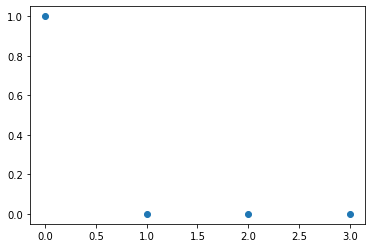

In [24]:
# df_appl = df_hr.loc[df_hr["수험번호"]==no_appls[0]].sort_values('#citation', ascending=False)
plt.scatter(range(df_appl.shape[0]), df_appl['#citation'])

In [20]:
citations = df_appl['#citation'].values
h_index = np.array(citations >= np.linspace(1, df_appl.shape[0], df_appl.shape[0], dtype=int)).sum()

3

In [16]:
np.linspace(1, df_appl.shape[1], df_appl.shape[1], dtype=int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

In [5]:
# 피인용수

df_applicants = pd.read_excel("문헌조사결과_수정DOI.xlsx")
df_applicants["no_citedby"] = np.nan
df_applicants["Notes_H"] = np.nan
df_applicants

,전체순번,수험번호내 순번,수험번호,이름,영문명,논문제목,게재일자,수정 DOI,논문구분\n(SCIE),Notes,no_citedby,Notes_H
0,1409,2,0088-000276,김재형,"Kim, Jae Hyung",A General Strategy to Atomically Dispersed Pre...,2020.01.30,10.1021/acsnano.9b08494,Y,NaN,NaN,NaN
1,683,3,0088-000129,유정원,"Yoo, Jeongwon",Investigation of intrinsic toroidal rotation s...,2017.07.12,10.1063/1.4991397,Y,논문 저자 이름이 약어로 표현됨. 확인 필요.,NaN,NaN
2,684,4,0088-000129,유정원,"Yoo, Jeongwon",Experimental evidence of intrinsic ohmic rotat...,2018.04.25,10.1063/1.5026905,Y,논문 저자 이름이 약어로 표현됨. 확인 필요.,NaN,NaN
3,1007,4,0088-000184,박준용,"Park, Junyong",Zirconium Oxide Post-treatment for TiO2 Photoe...,2015.06.10,10.1016/j.electacta.2015.06.022,Y,2015 이전 논문,NaN,NaN
4,1469,5,0088-000286,정민혜,"JEONG, Minhye",Rh-Mn/tungsten carbides for direct synthesis o...,2017.07.17,10.1016/j.micromeso.2017.07.026,Y,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1523,1099,10,0088-000206,박상진,"Park, Sang-Jin",200kW급 마이크로 가스터빈 연소기의 열-구조 연성해석,2014.07.01,10.5762/KAIS.2014.15.7.4093,NaN,doi 및 title 확인 필요,NaN,NaN
1524,722,1,0088-000136,김가영,"Kim, Gayoung",Transparent Thin-Film Silicon Solar Cells for ...,2020.05.07,10.1021/acsami.0c04517,Y,NaN,NaN,NaN
1525,725,4,0088-000136,김가영,"Kim, Gayoung",Effects of Moisture-Proof Back Passivation Lay...,2021.01.25,10.1021/acsami.0c17245,Y,NaN,NaN,NaN
1526,156,3,0088-000036,류근환,"Ryu, Geunhwan","Ultra-Lightweight, Flexible InGaP/GaAs Tandem ...",2021.03.11,10.1021/acsami.1c00006,Y,NaN,NaN,NaN


In [6]:
# 수험번호

no_appls = df_applicants.sort_values(["수험번호", "이름"])["수험번호"].unique()


In [27]:
df_appls = []

for no_appl in no_appls:
    df_appl = df_applicants.loc[df_applicants["수험번호"]==no_appl]
    
    for idx in df_appl.index:
        doi = df_appl.loc[idx, "수정 DOI"]
        sci = df_appl.loc[idx, "논문구분\n(SCIE)"]
        
        s = ScopusSearch(f"DOI ({doi})", download=True, subscriber=subscriber).results
        if s == None:
            try:
                s = ScopusSearch(f"TITLE ({title})", download=True, subscriber=subscriber).results
                if s != None:
                    doi = s[0].doi
                    df_appl.loc[idx, "Notes_H"] = f"DOI 오류: {doi}"
                else:
                    print(f"- Index {idx} is invalid.")
                    df_appl.loc[idx, "Notes_H"] = "doi 및 title 확인 필요"
                    continue
            except:
                print(f"- Index {idx} is not accessible in Scopus.")
                df_appl.loc[idx, "Notes_H"] = "Scopus에서 접근 불가. 확인 필요"
                continue
        elif sci == "Y":
            info_scopus = s[0]
            year, date = regularize_date_publication(info_scopus.coverDisplayDate)
            if year >= YEAR_START:
                no_cited = info_scopus.citedby_count
                df_appl.loc[idx, "no_cited"] = no_cited
            else:
                df_appl.loc[idx, "Notes_H"] = f"{YEAR_START-1} 이전 논문"
            
    df_appls.append(df_appl)
            
df_result = pd.concat(df_appls, axis=0)

- Index 1363 is not accessible in Scopus.
- Index 1373 is not accessible in Scopus.
- Index 1374 is not accessible in Scopus.
- Index 533 is not accessible in Scopus.
- Index 475 is not accessible in Scopus.
- Index 1367 is not accessible in Scopus.
- Index 1090 is not accessible in Scopus.
- Index 1364 is not accessible in Scopus.
- Index 1501 is not accessible in Scopus.
- Index 1502 is not accessible in Scopus.
- Index 1503 is not accessible in Scopus.
- Index 1382 is not accessible in Scopus.
- Index 1352 is not accessible in Scopus.
- Index 1362 is not accessible in Scopus.
- Index 1381 is not accessible in Scopus.
- Index 1268 is not accessible in Scopus.
- Index 1220 is not accessible in Scopus.
- Index 1257 is not accessible in Scopus.
- Index 954 is not accessible in Scopus.
- Index 367 is not accessible in Scopus.
- Index 1099 is not accessible in Scopus.
- Index 1466 is not accessible in Scopus.
- Index 876 is not accessible in Scopus.
- Index 92 is not accessible in Scopus.

In [30]:
df_result.loc[df_applicants.index].to_excel("문헌조사결과_피인용수.xlsx")

In [3]:
df_CV = pd.read_excel("my_CV.xlsx")
df_CV.head()

,DOI,TITLE_Scopus
0,10.1021/acs.jpclett.1c01140,First-Principles-Based Machine-Learning Molecu...
1,10.1038/s41598-021-83315-9,Optimizing machine learning models for granula...
2,10.1038/srep31513,Resonant vortex-core reversal in magnetic nano...
3,10.1063/1.4919836,Temperature effect on vortex-core reversals in...
4,10.1038/srep11370,Resonantly exited precession motion of three-d...


In [15]:
dois = df_CV["DOI"]
df_CV["no_cited"] = 0
df_CV["Notes"] = np.nan

In [22]:
for idx in df_CV.index:
    doi = df_CV.loc[idx, "DOI"]
    s = ScopusSearch(f"DOI ({doi})", download=True, subscriber=subscriber).results
    if s == None:
        try:
            s = ScopusSearch(f"TITLE ({title})", download=True, subscriber=subscriber).results
            if s != None:
                doi = s[0].doi
                df_CV.loc[idx, "Notes"] = f"DOI 오류: {doi}"
            else:
                print(f"- No.{i} is invalid.")
                df_CV.loc[idx, "Notes"] = "doi 및 title 확인 필요"
                continue
        except:
            print(f"- No.{i} is not accessible in Scopus.")
            df_CV.loc[idx, "Notes"] = "Scopus에서 접근 불가. 확인 필요"
            continue
            
    info_scopus = s[0]
    no_cited = info_scopus.citedby_count
    df_CV.loc[idx, "no_cited"] = no_cited

In [23]:
df_CV

,DOI,TITLE_Scopus,no_cited,Notes
0,10.1021/acs.jpclett.1c01140,First-Principles-Based Machine-Learning Molecu...,1,NaN
1,10.1038/s41598-021-83315-9,Optimizing machine learning models for granula...,2,NaN
2,10.1038/srep31513,Resonant vortex-core reversal in magnetic nano...,6,NaN
3,10.1063/1.4919836,Temperature effect on vortex-core reversals in...,1,NaN
4,10.1038/srep11370,Resonantly exited precession motion of three-d...,13,NaN
5,10.1063/1.4903741,Self-assembled magnetic nanospheres with three...,14,NaN
6,10.1002/adma.201303003,Magnetic microstructure of rolled-up single-la...,59,NaN
7,10.1088/0957-4484/25/4/045604,Scaling dependence and tailoring of the pinnin...,10,NaN
8,10.1142/S2010324713400018,Rolled-up permalloy nanomembranes with multipl...,13,NaN
9,10.1088/0957-4484/24/14/145702,Probing the energy barriers and magnetization ...,13,NaN
